In [1]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.formatter.useoffset'] = False

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

#%config InlineBackend.figure_format='retina'

In [2]:
import utils.load_grid as lg
from utils.load_cmaps import *

### Read data

In [3]:
pgrid_dir = "data/shared/pgrid_earth_gridtest_14"
cases = lg.get_cases(pgrid_dir)
ncases = len(cases)

In [4]:
# Collect netcdf files
stts = lg.get_statuses(pgrid_dir)
endn = lg.load_netcdfs_end(cases)

# Configuration variables
cvars = lg.load_cvars(cases)

# Helpfiles
helps, hvars = lg.load_helpfiles(cases)

print("Done")

Helpfiles: 100%|██████████| 96/96 [00:02<00:00, 43.61it/s]


Done


### Function to plot z vs x,y scatter graphs

In [22]:
def make_s2d(x,x_lbl, y,y_lbl, z,z_lbl, control, plot_scatter=True, plot_casenums=False, plot_controls=False,  logx=False,logy=False,logz=False, interp='none',):
    # Make plot
    x_plt = np.array([], dtype=float) # x variable
    y_plt = np.array([], dtype=float) # y variable 
    z_plt = np.array([], dtype=float) # z variable
    c_plt = np.array([], dtype=int)   # case number
    g_plt = np.array([], dtype=bool)  # case finished with success? (good)
    g_plt = np.array([], dtype=bool)  # case finished with failure? (bad)
    for i in range(len(x)):
        skip_this = False
        for k in control.keys():
            if k in cvars.keys():
                if not np.isclose(cvars[k][i],control[k]):
                    skip_this = True
                    break
        if skip_this:
            continue 
        x_plt = np.append(x_plt, x[i])
        y_plt = np.append(y_plt, y[i])
        z_plt = np.append(z_plt, z[i])
        c_plt = np.append(c_plt, i)
        g_plt = np.append(g_plt, bool( 10 <= stts[i] <= 19))
    if len(z_plt) == 0:
        print("WARNING: No data left after applying control variables!")
        return

    b_plt = np.invert(g_plt)
    
    interp = interp.lower().strip()
    do_interp =  interp in ['contour', 'mesh']
    if do_interp:
        x_inp = sorted(list(set(x_plt)))
        y_inp = sorted(list(set(y_plt)))
        z_2d = np.reshape(z_plt, (len(x_inp),len(y_inp)))
        _,_,xxi,yyi,zzi = lg.interp_2d(x_inp,y_inp,z_2d, 1000, method='linear')
        
    if not logz:
        norm = mpl.colors.Normalize(vmin=np.amin(z_plt), vmax=np.amax(z_plt))
    else:
        norm = mpl.colors.LogNorm(vmin=np.amin(z_plt), vmax=np.amax(z_plt))
    cmap = sci_colormaps['batlow']
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    marker_e = 'none'
    marker_s = 220

    # Make the plot
    fig,ax = plt.subplots(1,1, figsize=(5,4))

    if do_interp:
        if interp == 'contour':
            ax.contourf(xxi,yyi,zzi, cmap=cmap, norm=norm)
        else:
            ax.pcolormesh(xxi,yyi,zzi, cmap=cmap, norm=norm)
        marker_e='white'

    if plot_scatter:
        ax.scatter(x_plt[g_plt], y_plt[g_plt], c=z_plt[g_plt], norm=norm, cmap=cmap, marker='s', s=marker_s, edgecolors=marker_e, zorder=3)
        ax.scatter(x_plt[b_plt], y_plt[b_plt], c=z_plt[b_plt], norm=norm, cmap=cmap, marker='o', s=marker_s, edgecolors=marker_e, zorder=3)

    if plot_casenums:
        for i in range(len(x_plt)):
            ax.text(x_plt[i],y_plt[i],c_plt[i],fontsize=7, color='magenta', horizontalalignment='center', verticalalignment='center')

    if plot_controls:
        control_str = "Control variables:\n"
        for k in control.keys():
            control_str += "  %s=%g\n" % (k,control[k])
        control_str = control_str[:-1]
        axt = ax.text(0.05, 0.95, control_str, 
                horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=10)
        axt.set_bbox(dict(facecolor='white', alpha=0.5, linewidth=0))

    ax.set_xlabel(x_lbl)
    ax.set_ylabel(y_lbl)
    if logx:
        ax.set_xscale("log")
    if logy:
        ax.set_yscale("log")

    cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
    fig.colorbar(sm, cax=cax, orientation='vertical').set_label(z_lbl) 

    return fig,ax

### Function to plot z vs x using line graphs

In [23]:
def make_p1d(x,x_lbl, z,z_lbl, control, plot_controls=False, logx=False, logz=False):
    # Make plot
    x_plt = np.array([], dtype=float) # x variable
    z_plt = np.array([], dtype=float) # z variable
    c_plt = np.array([], dtype=int)   # case number
    g_plt = np.array([], dtype=bool)  # case finished with success? (good)
    g_plt = np.array([], dtype=bool)  # case finished with failure? (bad)
    for i in range(len(x)):
        skip_this = False
        for k in control.keys():
            if k in cvars.keys():
                if not np.isclose(cvars[k][i],control[k]):
                    skip_this = True
                    break
        if skip_this:
            continue 
        x_plt = np.append(x_plt, x[i])
        z_plt = np.append(z_plt, z[i])
        c_plt = np.append(c_plt, i)
        g_plt = np.append(g_plt, bool( 10 <= stts[i] <= 19))
    if len(z_plt) == 0:
        print("WARNING: No data left after applying control variables!")
        return

    b_plt = np.invert(g_plt)
        
    fig,ax = plt.subplots(1,1, figsize=(5,4))

    x_mask = np.argsort(x_plt)
    x_srt = x_plt[x_mask]
    z_srt = z_plt[x_mask]

    ax.plot(x_srt, z_srt, color='k', lw=3, zorder=3)
    ax.scatter(x_srt, z_srt, marker='s', s=30, zorder=4)
    ax.scatter(x_plt[b_plt], z_plt[b_plt], marker='x', s=30, zorder=4)

    if plot_controls:
        control_str = "Control variables:\n"
        for k in control.keys():
            control_str += "  %s=%g\n" % (k,control[k])
        control_str = control_str[:-1]
        axt = ax.text(0.05, 0.95, control_str, 
                horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=10)
        axt.set_bbox(dict(facecolor='white', alpha=0.5, linewidth=0))

    ax.set_xlabel(x_lbl)
    ax.set_ylabel(z_lbl)
    if logz:
        ax.set_yscale("log")
    if logx:
        ax.set_xscale("log")

    return fig,ax



### Make the plots

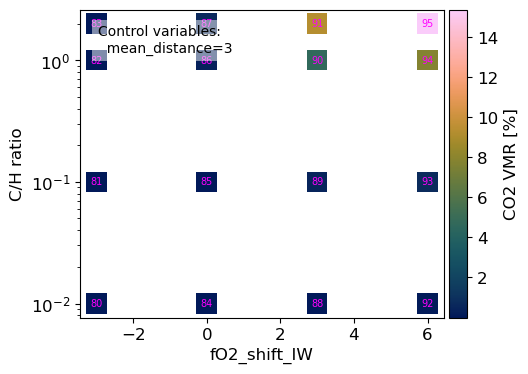

In [26]:
x = cvars["fO2_shift_IW"];  x_lbl = "fO2_shift_IW"; logx = False 
y = cvars["CH_ratio"];      y_lbl = "C/H ratio";    logy = True

# z = lg.access_hvars(hvars,"P_surf",-1); z_lbl = "Surface pressure [bar]"
# z = lg.access_hvars(hvars,"Time",-1);  z_lbl = "Termination [Myr]"
z = lg.access_hvars(hvars,"CO2_mr",-1) * 100; z_lbl = "CO2 VMR [%]"
control = {"mean_distance":3.0}

plot_controls = True
plot_casenums = True
plot_scatter  = True 
interp        = 'mesh'
logz = False

make_s2d(x,x_lbl, y,y_lbl, z,z_lbl, control, 
         plot_scatter=plot_scatter,plot_casenums=plot_casenums, plot_controls=plot_controls, 
         logx=logx, logy=logy, logz=logz, 
         interp='interp')
plt.show()


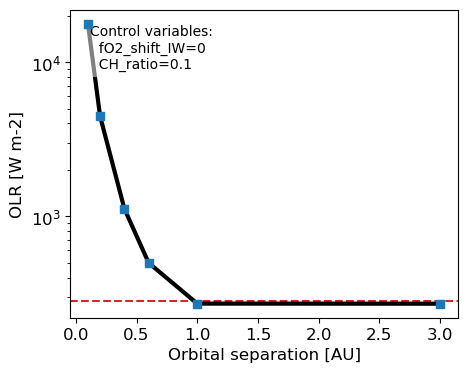

In [25]:
x = cvars["mean_distance"];  x_lbl = "Orbital separation [AU]"; logx = False
z = np.array([ endn[i]["fl_U_LW"][0] for i in range(ncases) ]); z_lbl = "OLR [W m-2]"
# z = endt * 1.0e-3; z_lbl = "Termination time [yr]"
control = {"fO2_shift_IW":0, "CH_ratio":0.1}

plot_controls = True
logz = True

fig,ax = make_p1d(x,x_lbl, z,z_lbl, control, plot_controls=plot_controls, logx=logx, logz=logz)
ax.axhline(y=280, linestyle='dashed',zorder=2, label="SN Limit", color='tab:red')
plt.show()

